In [27]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb
import random
import neurokit2 as nk

In [8]:
patients_database = pd.read_csv('physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv')
scp_statements = pd.read_csv('physionet.org/files/ptb-xl/1.0.3/scp_statements.csv', index_col=0)

In [9]:
patients_database.head()

ecg_id  patient_id   age  sex  height  weight  nurse  site     device  \
0       1     15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
1       2     13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
2       3     20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
3       4     17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
4       5     17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

        recording_date  ... validated_by_human  baseline_drift static_noise  \
0  1984-11-09 09:17:34  ...               True             NaN    , I-V1,     
1  1984-11-14 12:55:37  ...               True             NaN          NaN   
2  1984-11-15 12:49:10  ...               True             NaN          NaN   
3  1984-11-15 13:44:57  ...               True    , II,III,AVF          NaN   
4  1984-11-17 10:43:15  ...               True   , III,AVR,AVF          NaN   

  burst_noise electrodes_problems  extra_beats  pacemaker  strat_fold  \
0         NaN                 NaN          NaN        NaN           3   
1         NaN                 NaN          NaN        NaN           2   
2         NaN                 NaN          NaN        NaN           5   
3         NaN                 NaN          NaN        NaN           3   
4         NaN                 NaN          NaN        NaN           4   

                 filename_lr                filename_hr  
0  records100/00000/00001_lr  records500/00000/00001_hr  
1  records100/00000/00002_lr  records500/00000/00002_hr  
2  records100/00000/00003_lr  records500/00000/00003_hr  
3  records100/00000/00004_lr  records500/00000/00004_hr  
4  records100/00000/00005_lr  records500/00000/00005_hr  

[5 rows x 28 columns]

In [10]:
scp_statements.head()

description  diagnostic  form  rhythm  \
NDT    non-diagnostic T abnormalities         1.0   1.0     NaN   
NST_          non-specific ST changes         1.0   1.0     NaN   
DIG                  digitalis-effect         1.0   1.0     NaN   
LNGQT                long QT-interval         1.0   1.0     NaN   
NORM                       normal ECG         1.0   NaN     NaN   

      diagnostic_class diagnostic_subclass  \
NDT               STTC                STTC   
NST_              STTC                NST_   
DIG               STTC                STTC   
LNGQT             STTC                STTC   
NORM              NORM                NORM   

                                      Statement Category  \
NDT                    other ST-T descriptive statements   
NST_   Basic roots for coding ST-T changes and abnorm...   
DIG                    other ST-T descriptive statements   
LNGQT                  other ST-T descriptive statements   
NORM                                     Normal/abnormal   

        SCP-ECG Statement Description  AHA code            aECG REFID  \
NDT    non-diagnostic T abnormalities       NaN                   NaN   
NST_          non-specific ST changes     145.0  MDC_ECG_RHY_STHILOST   
DIG         suggests digitalis-effect     205.0                   NaN   
LNGQT                long QT-interval     148.0                   NaN   
NORM                       normal ECG       1.0                   NaN   

      CDISC Code DICOM Code  
NDT          NaN        NaN  
NST_         NaN        NaN  
DIG          NaN        NaN  
LNGQT        NaN        NaN  
NORM         NaN    F-000B7

In [11]:
file = open('patient_scp.csv', 'w', newline='')
writer = csv.writer(file)
writer.writerow(['ecg_id', 'patient_id', 'label','scp','filename_lr', 'filename_hr', 'age', 'sex', 'weight', 'height', 'device', 'report'])

def retrieve_class(d):
    return max(d, key=d.get)

for index, row in patients_database.iterrows():
    scp_codes = eval(row['scp_codes'])
    
    scp_label = retrieve_class(scp_codes)
 
    label_row = scp_statements.loc[scp_label]
    label = label_row['diagnostic_class']
    
    if pd.isna(label):
        label = scp_label
        continue

    if row['age'] > 120 or row['age'] < 0:
        continue

    writer.writerow([row['ecg_id'], row['patient_id'],label, scp_label, row['filename_lr'], row['filename_hr'], row['age'], row['sex'], row['weight'], row['height'], row['device'], row['report']])

file.close()

In [12]:
patient_scp = pd.read_csv('patient_scp.csv')

In [13]:
classes = patient_scp['label'].unique()
print(classes)

['NORM' 'MI' 'STTC' 'HYP' 'CD']


In [14]:
for label in classes:
    print(label, len(patient_scp[patient_scp['label'] == label]))

NORM 9104
MI 4027
STTC 3252
HYP 1254
CD 3223


[54.33875219683656, 36.03178544822448, 54.52029520295203, 42.663476874003194, 38.56655290102389]
[45.66124780316345, 63.96821455177552, 45.47970479704797, 57.336523125996806, 61.43344709897611]


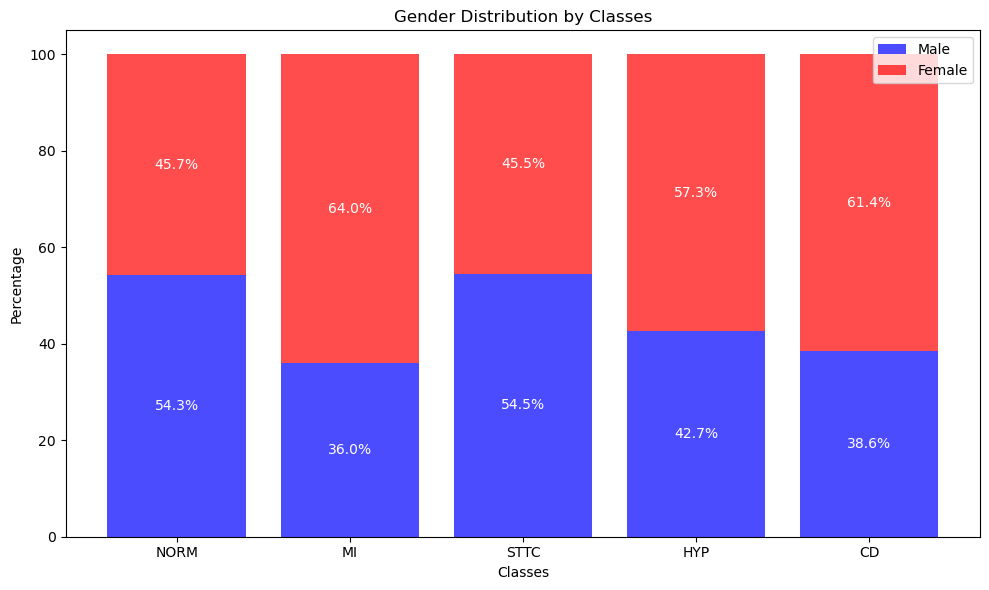

In [15]:
male_data = []
female_data = []

for label in classes:
    label_data = patient_scp[patient_scp['label'] == label]
    male_count = len(label_data[label_data['sex'] == 1])
    female_count = len(label_data[label_data['sex'] == 0])

    male_data.append(male_count / (male_count + female_count) * 100)
    female_data.append(female_count / (male_count + female_count) * 100)

print(male_data)
print(female_data)


# Bar plot parameters
x = np.arange(len(classes))  # the label locations
width = 0.8  # the width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot data
ax.bar(x, male_data, width, label='Male', color='blue', alpha=0.7)
ax.bar(x, female_data, width, bottom=male_data, label='Female', color='red', alpha=0.7)

for i in range(len(classes)):
    # Male percentage
    ax.text(x[i], male_data[i] / 2, f"{male_data[i]:.1f}%", ha='center', va='center', color='white', fontsize=10)
    # Female percentage
    ax.text(x[i], male_data[i] + (female_data[i] / 2), f"{female_data[i]:.1f}%", ha='center', va='center', color='white', fontsize=10)

# Labels, title, and legend
ax.set_xlabel('Classes')
ax.set_ylabel('Percentage')
ax.set_title('Gender Distribution by Classes')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

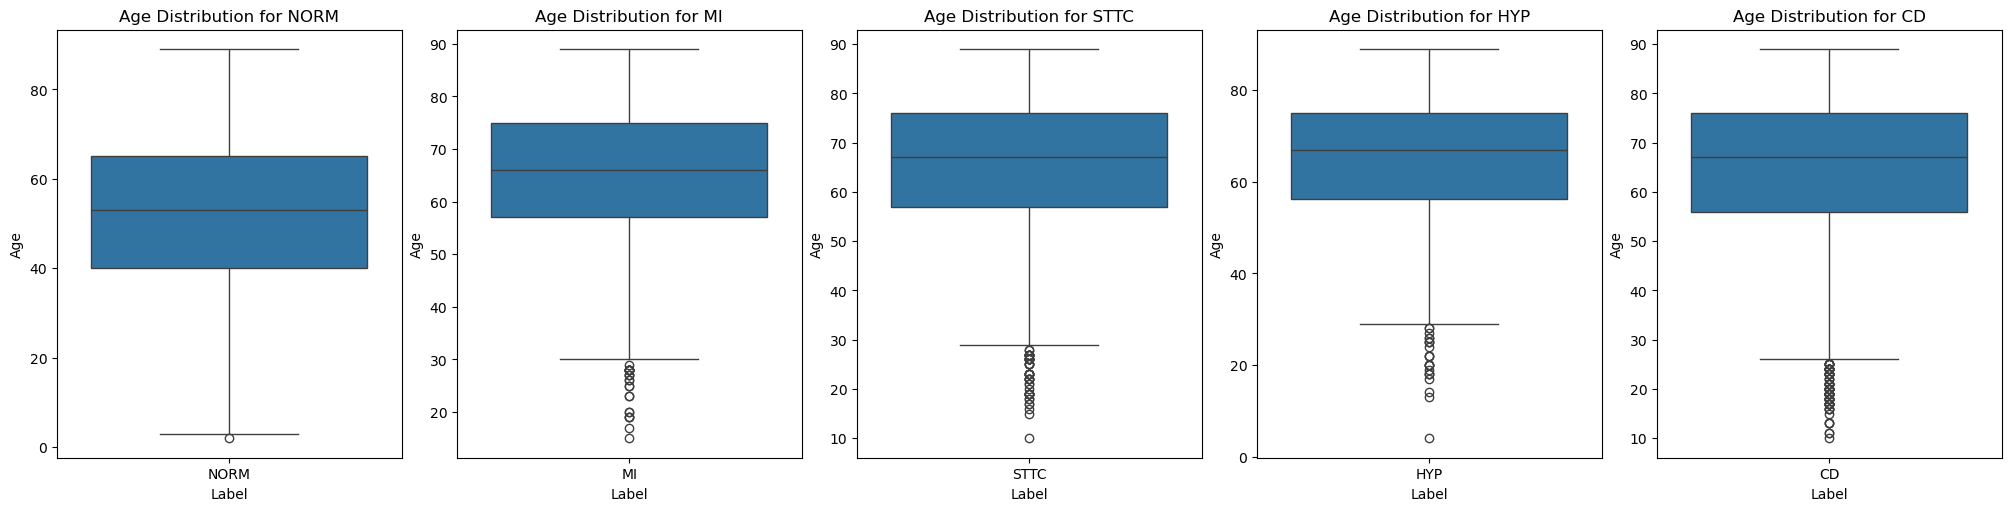

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(1, 5, figsize=(20, 5), constrained_layout=True)

# Flatten axes for easy indexing (in case of multiple rows)
axes = axes.flatten()

# Generate plots
for idx, label in enumerate(classes):
    sns.boxplot(ax=axes[idx], x='label', y='age', data=patient_scp[patient_scp['label'] == label])
    axes[idx].set_title(f'Age Distribution for {label}')
    axes[idx].set_xlabel('Label')
    axes[idx].set_ylabel('Age')

# Hide any unused subplots (if the total number of classes is less than the grid size)
for idx in range(len(classes), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

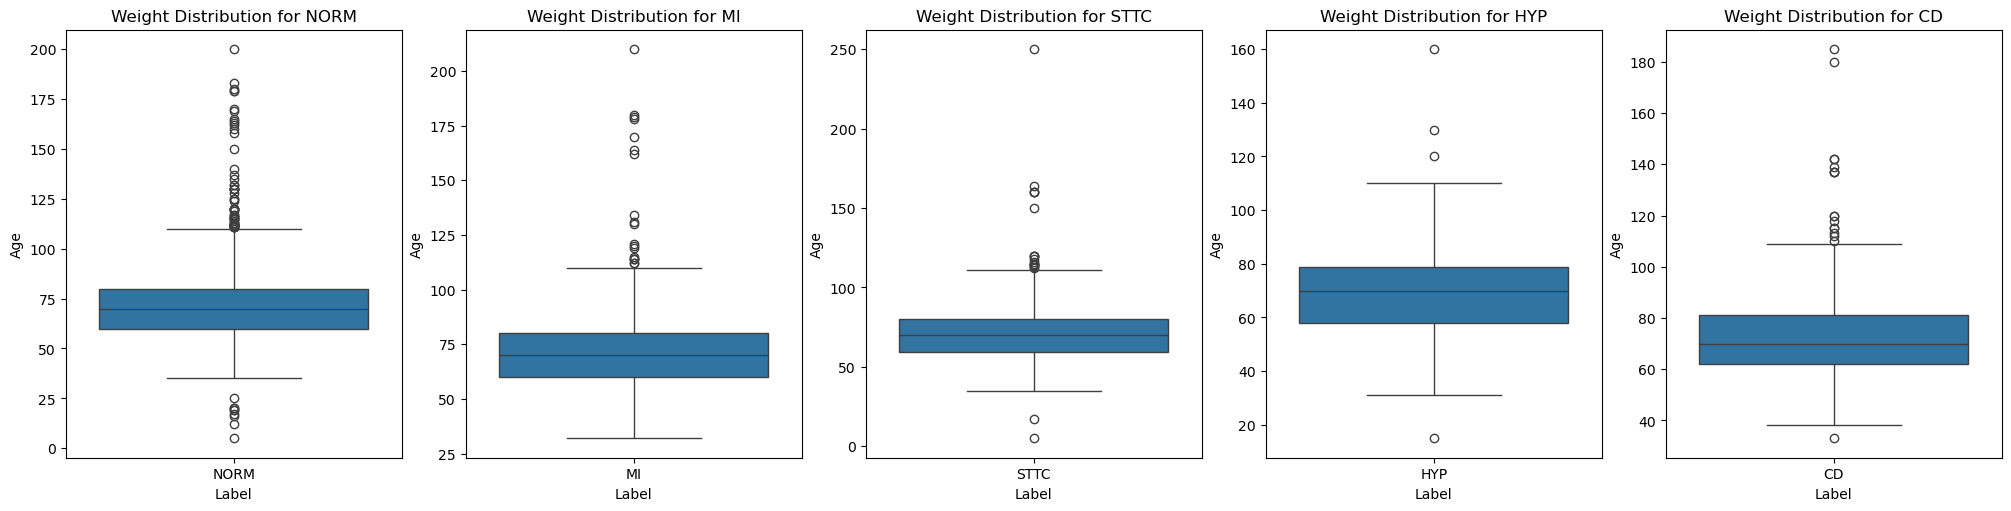

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(1, 5, figsize=(20, 5), constrained_layout=True)

# Flatten axes for easy indexing (in case of multiple rows)
axes = axes.flatten()

# Generate plots
for idx, label in enumerate(classes):
    sns.boxplot(ax=axes[idx], x='label', y='weight', data=patient_scp[patient_scp['label'] == label])
    axes[idx].set_title(f'Weight Distribution for {label}')
    axes[idx].set_xlabel('Label')
    axes[idx].set_ylabel('Age')

# Hide any unused subplots (if the total number of classes is less than the grid size)
for idx in range(len(classes), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

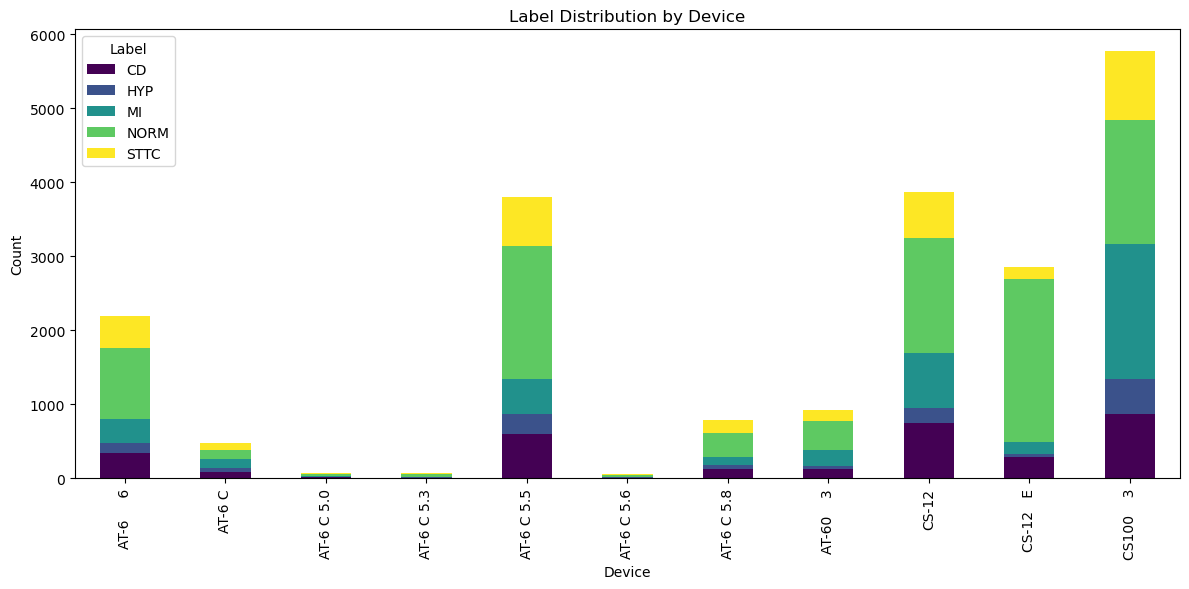

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Example grouped data
device_label_counts = patient_scp.groupby(['device', 'label']).size().unstack()

# Plot
device_label_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Label Distribution by Device')
plt.xlabel('Device')
plt.ylabel('Count')
plt.legend(title='Label')
plt.tight_layout()
plt.show()

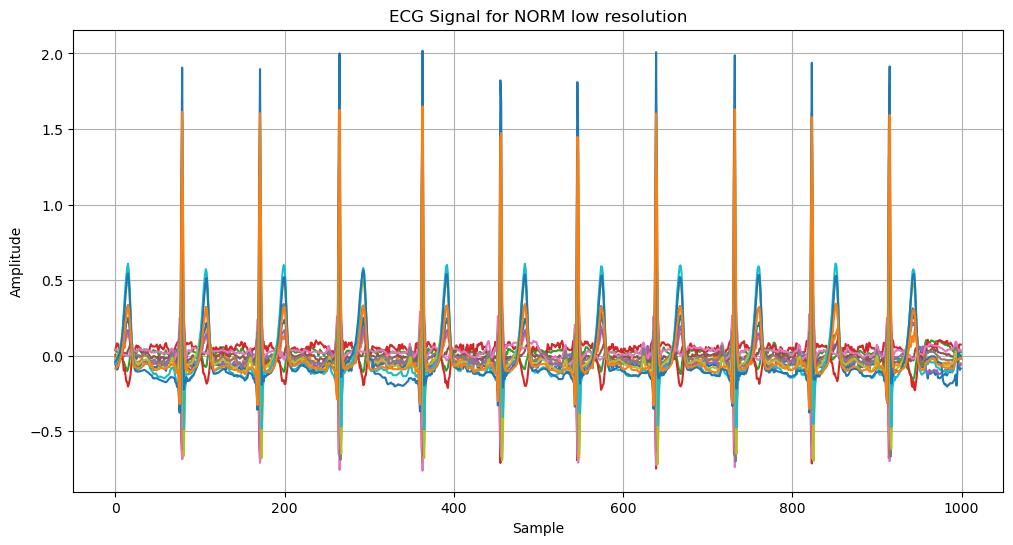

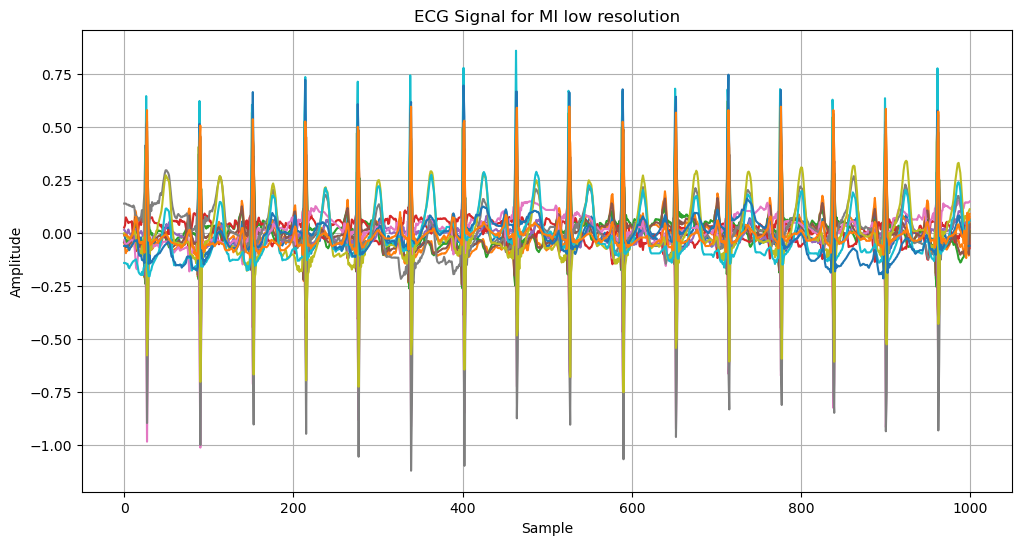

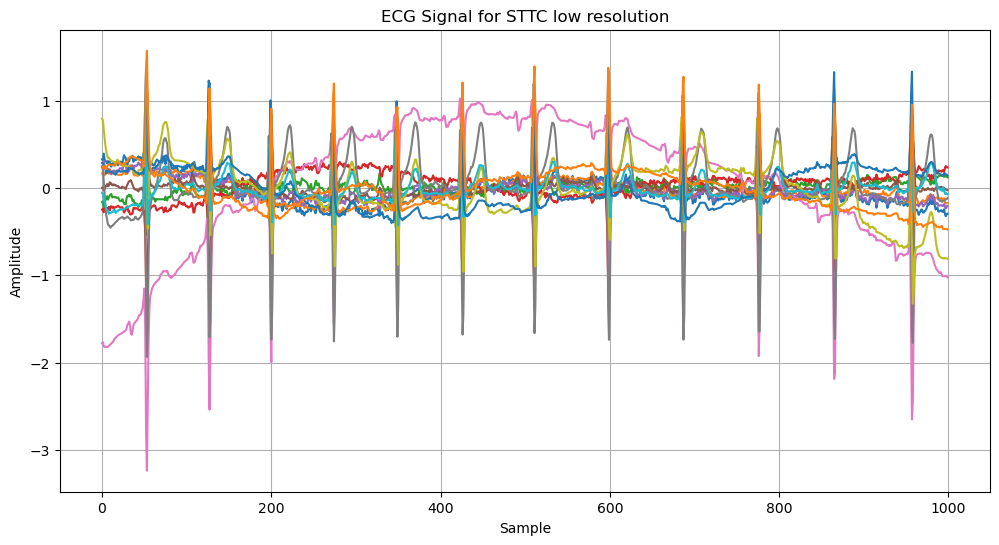

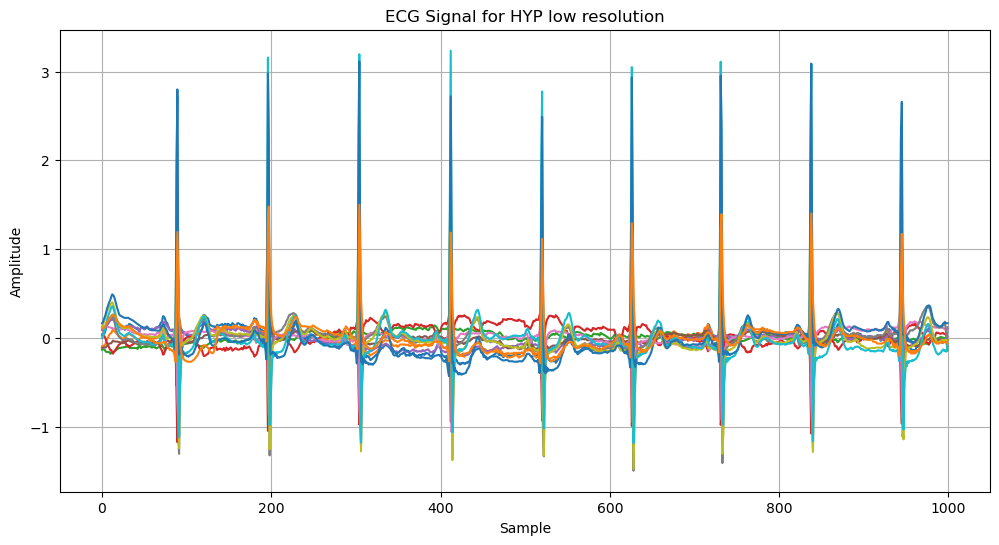

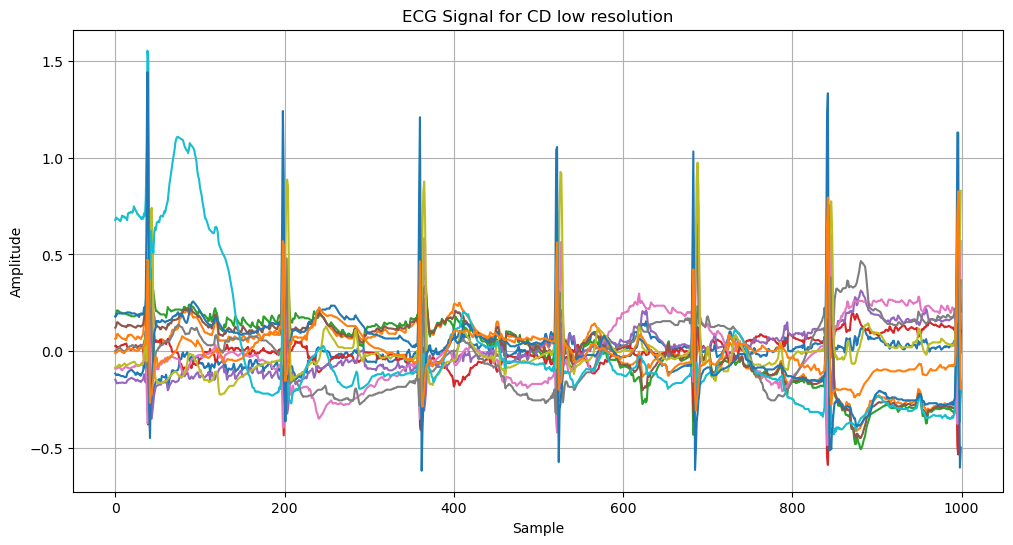

In [29]:
directory = 'physionet.org/files/ptb-xl/1.0.3/'
chosen_random_samples = []
for label in classes:
    class_data = patient_scp[patient_scp['label'] == label]
    random_id = random.choice(class_data['ecg_id'].values)
    random_sample_row = class_data[class_data['ecg_id'] == random_id]
    chosen_random_samples.append(random_sample_row)
    record = wfdb.rdrecord(directory + random_sample_row['filename_r'].values[0])
    signals = record.p_signal

    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=s_rate)

    plt.figure(figsize=(12, 6))
    plt.plot(signals)
    plt.title(f'ECG Signal for {label} low resolution')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

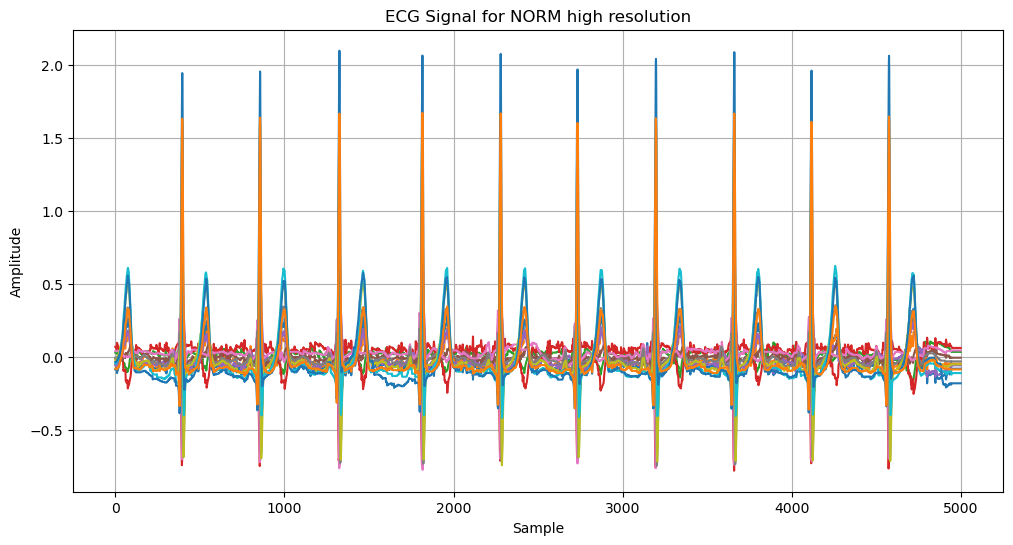

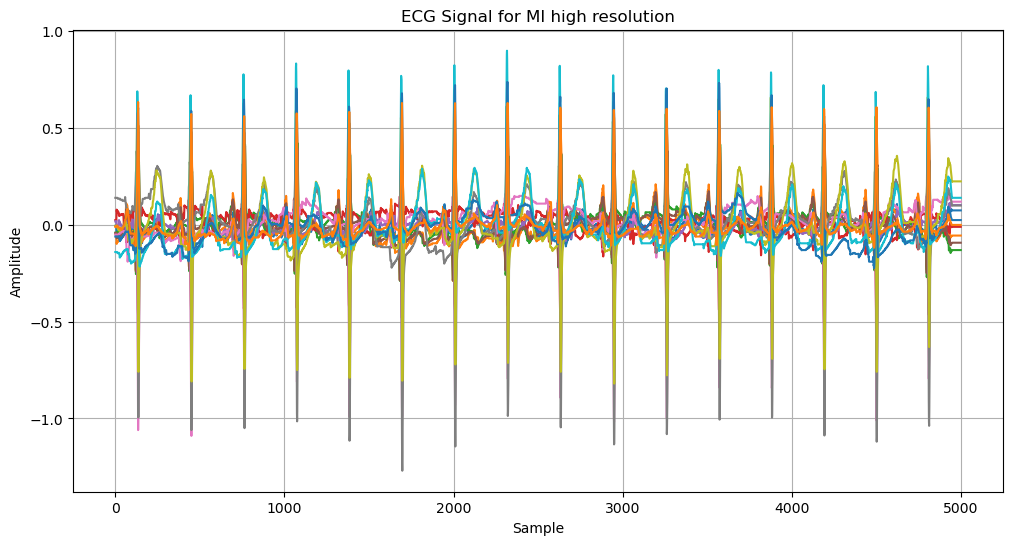

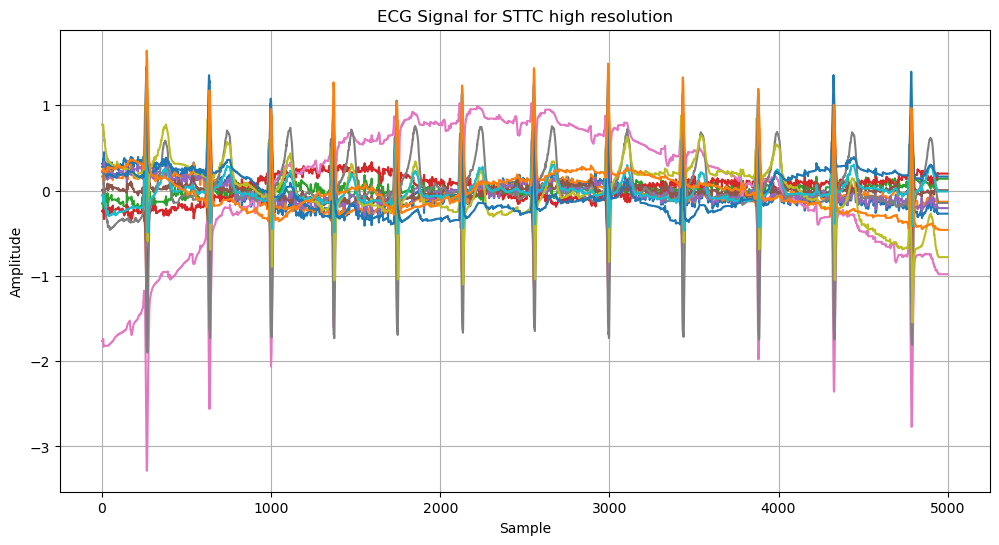

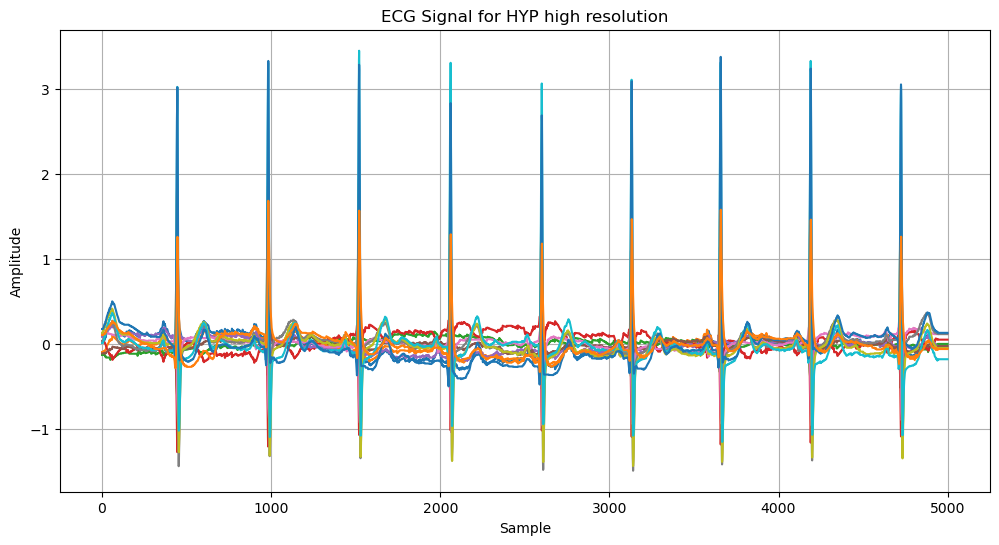

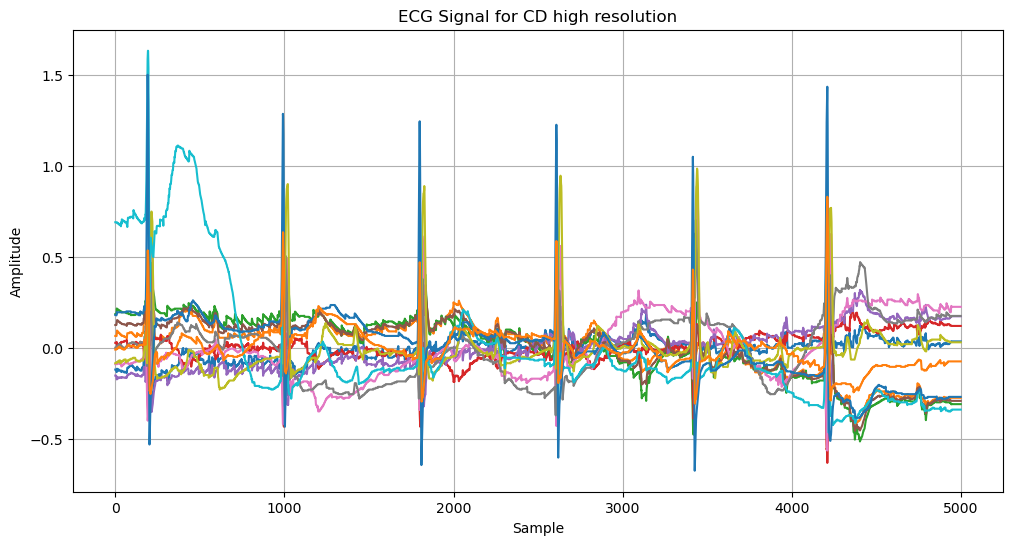

In [30]:
directory = 'physionet.org/files/ptb-xl/1.0.3/'

for i in range(len(classes)):
    label = classes[i]
    random_sample_row = chosen_random_samples[i]
    record = wfdb.rdrecord(directory + random_sample_row['filename_hr'].values[0])
    signals = record.p_signal
    ecg_signal = record.p_signal[:, 0]
    

    plt.figure(figsize=(12, 6))
    plt.plot(signals)
    plt.title(f'ECG Signal for {label} high resolution')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

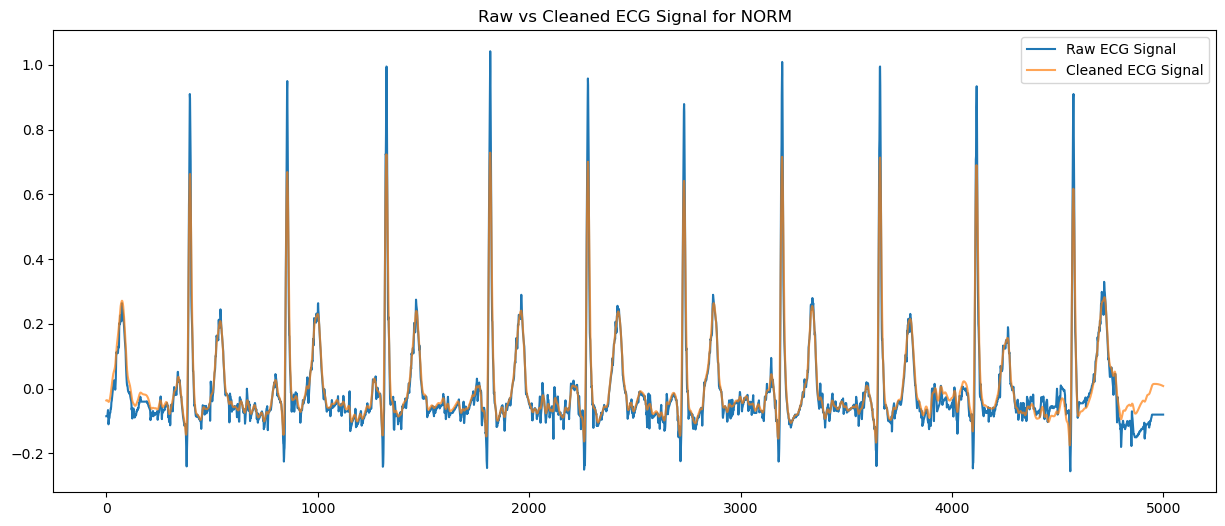

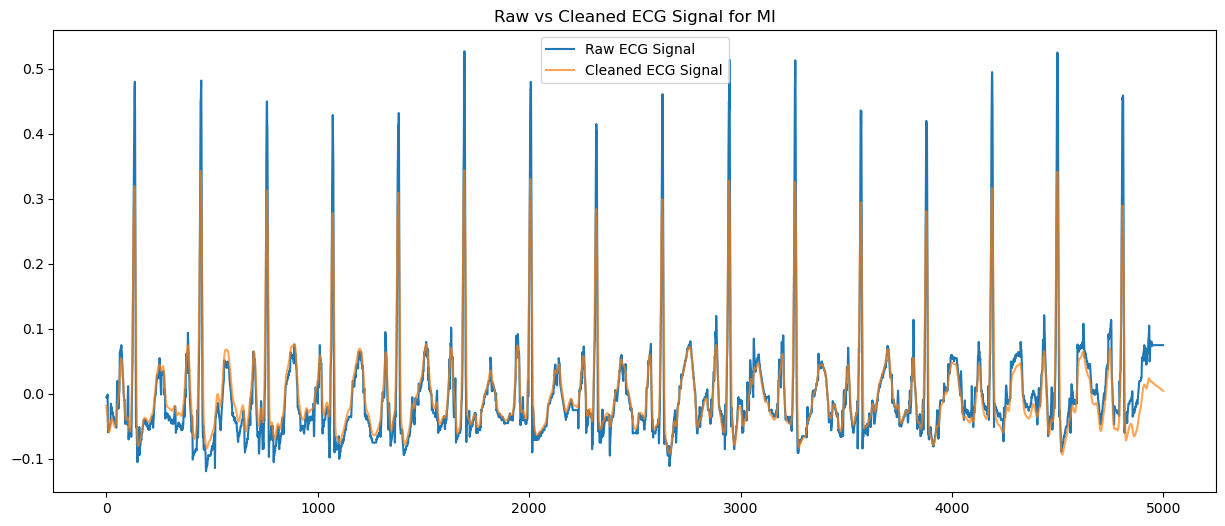

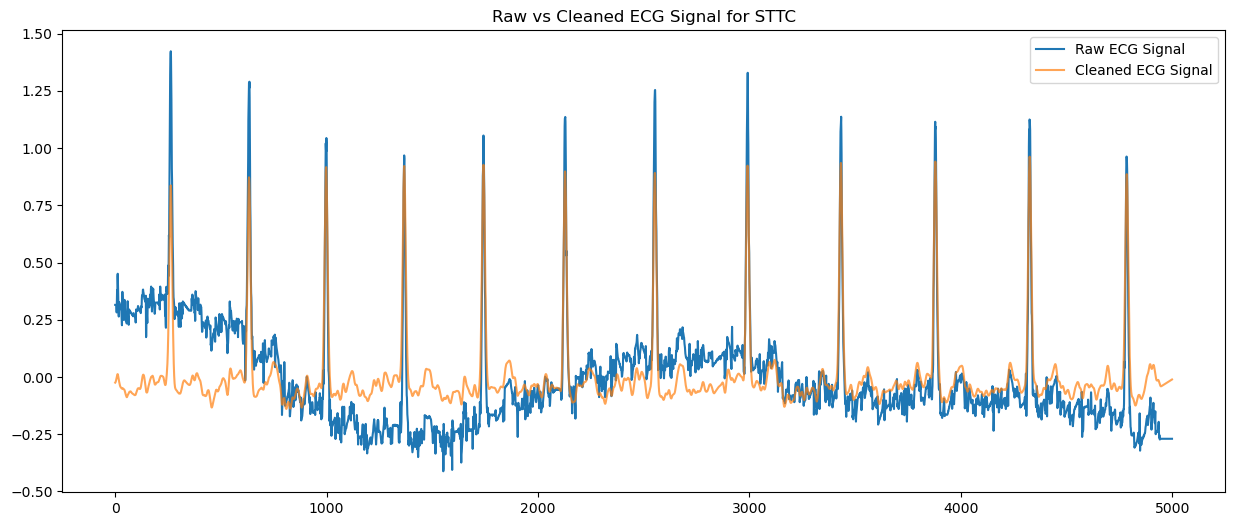

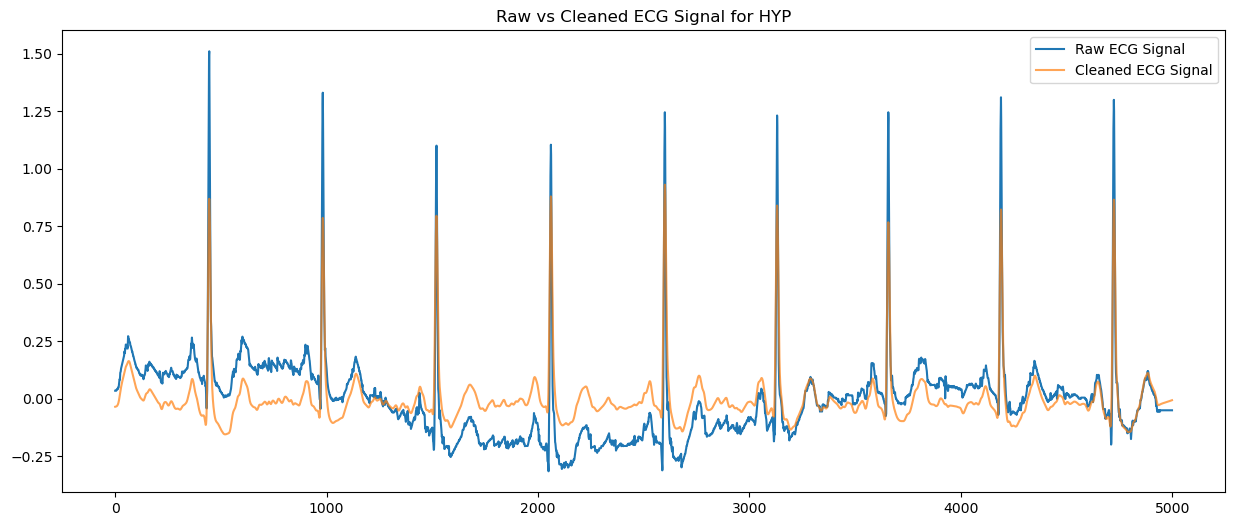

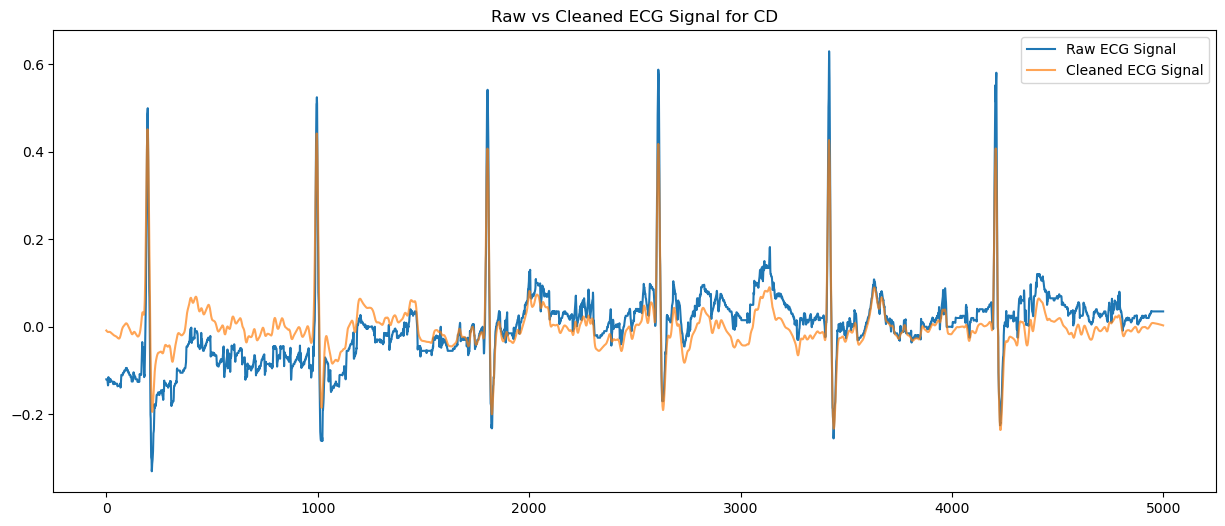

In [49]:
for i in range(len(classes)):
    label = classes[i]
    random_sample_row = chosen_random_samples[i]
    record = wfdb.rdrecord(directory + random_sample_row['filename_hr'].values[0])
    signals = record.p_signal
    ecg_signal = record.p_signal[:, 0]
    s_rate = 500
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=s_rate)

    plt.figure(figsize=(15, 6))
    plt.plot(ecg_signal, label="Raw ECG Signal")
    plt.plot(ecg_cleaned, label="Cleaned ECG Signal", alpha=0.7)
    plt.legend()
    plt.title(f"Raw vs Cleaned ECG Signal for {label}")
    plt.show()

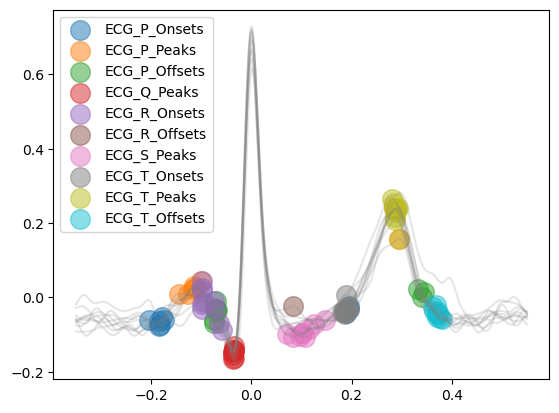

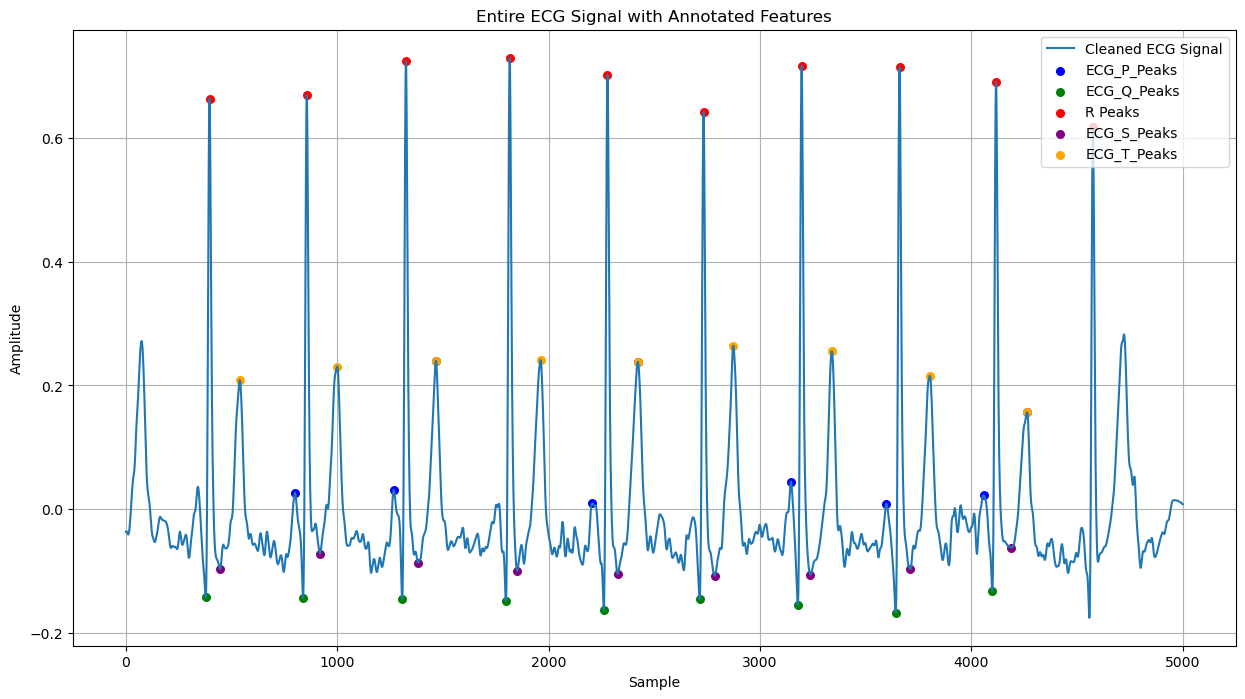

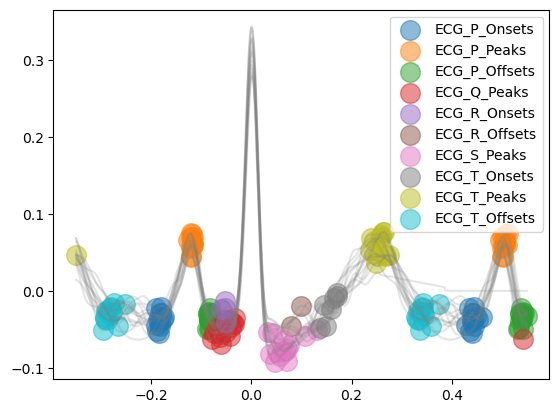

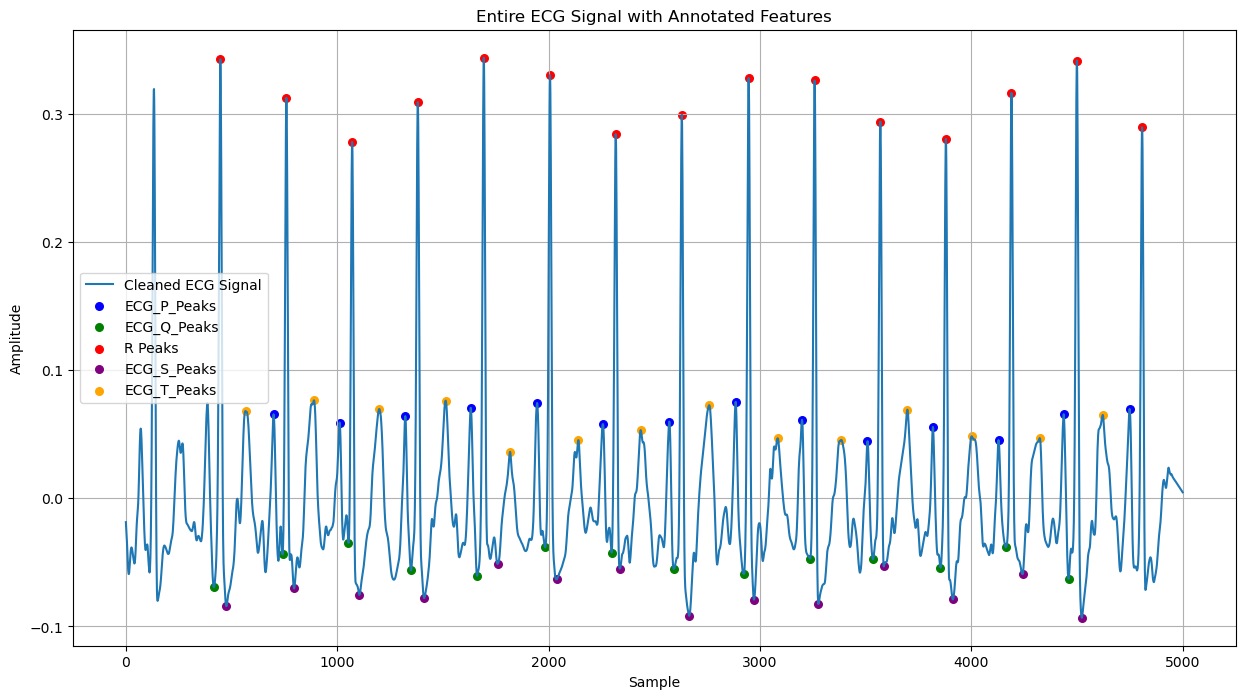

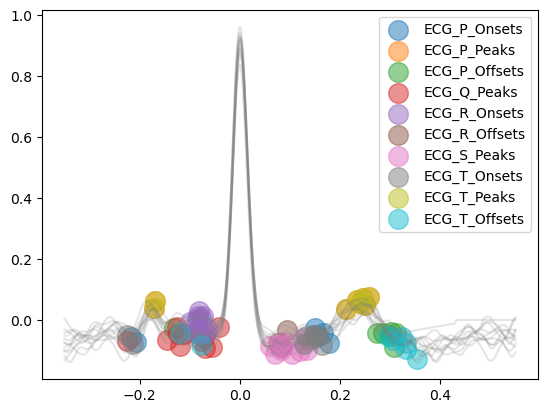

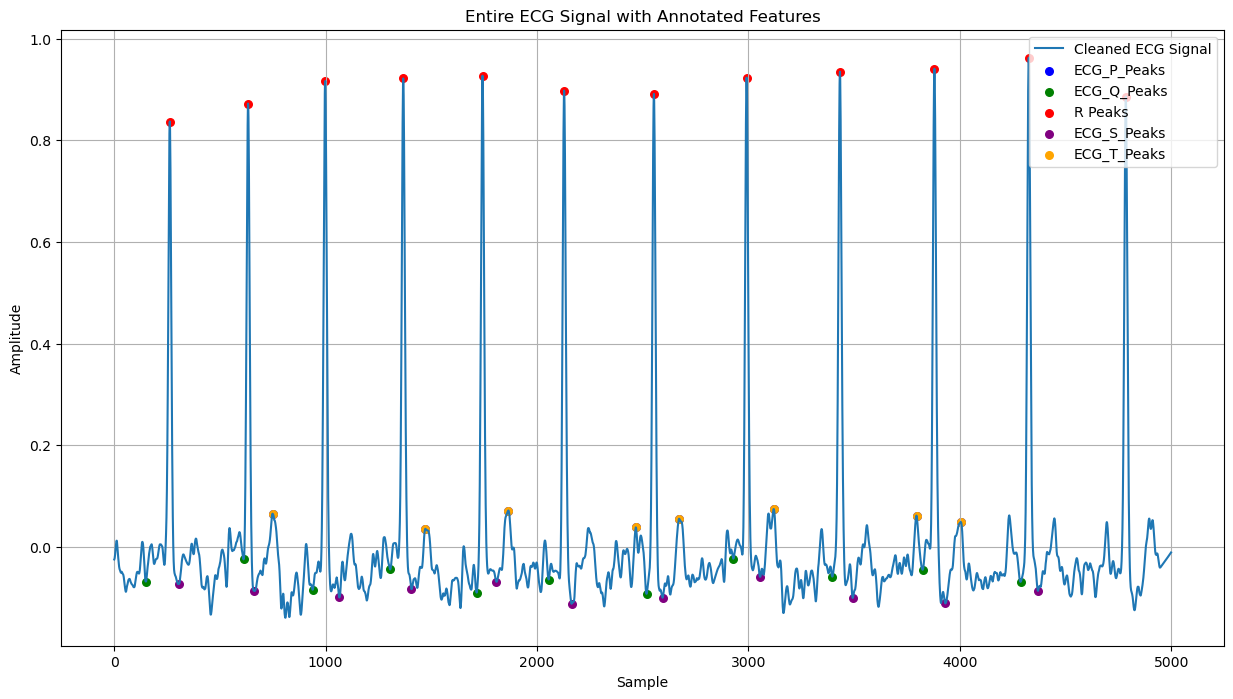

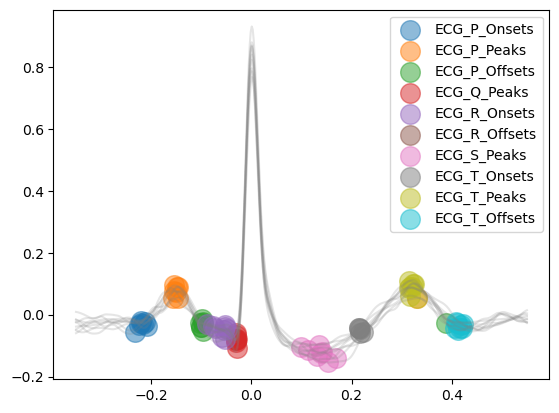

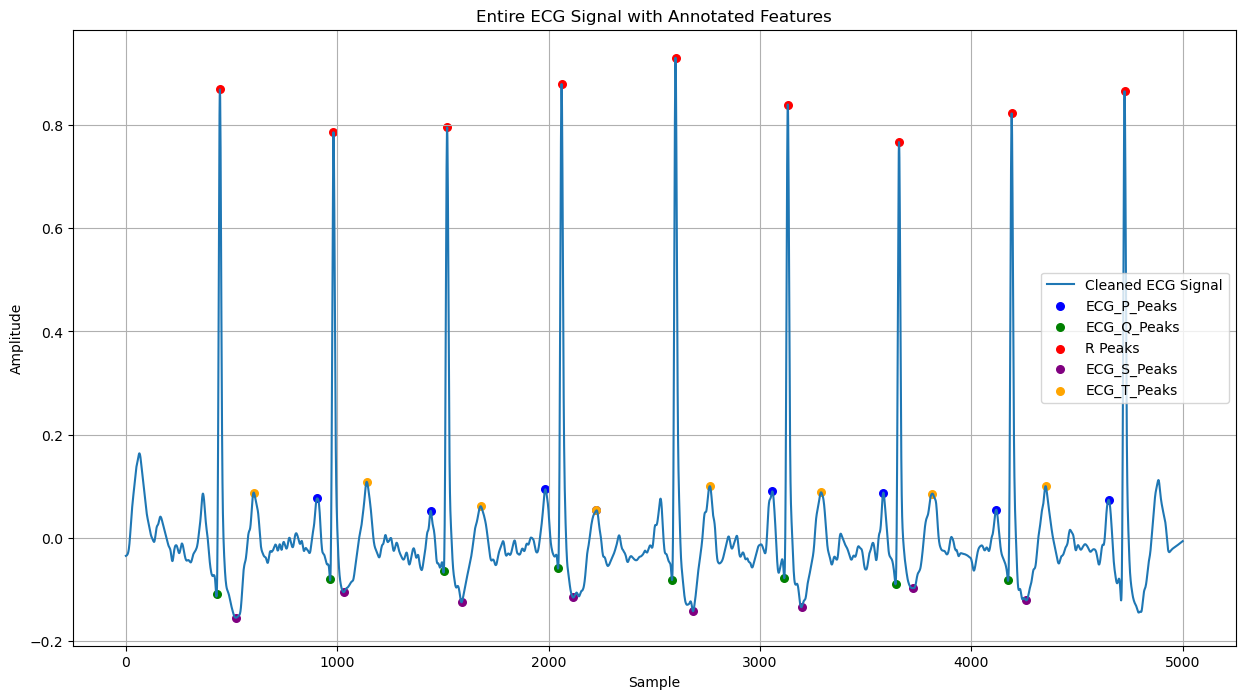

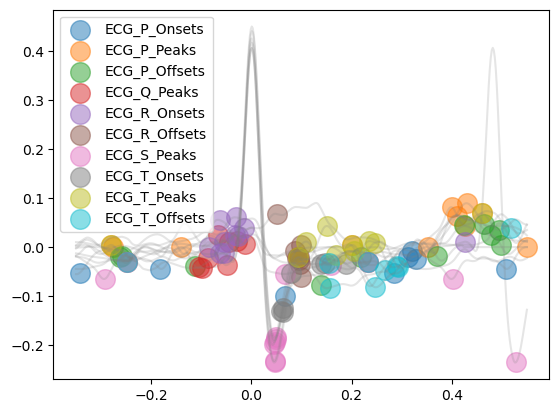

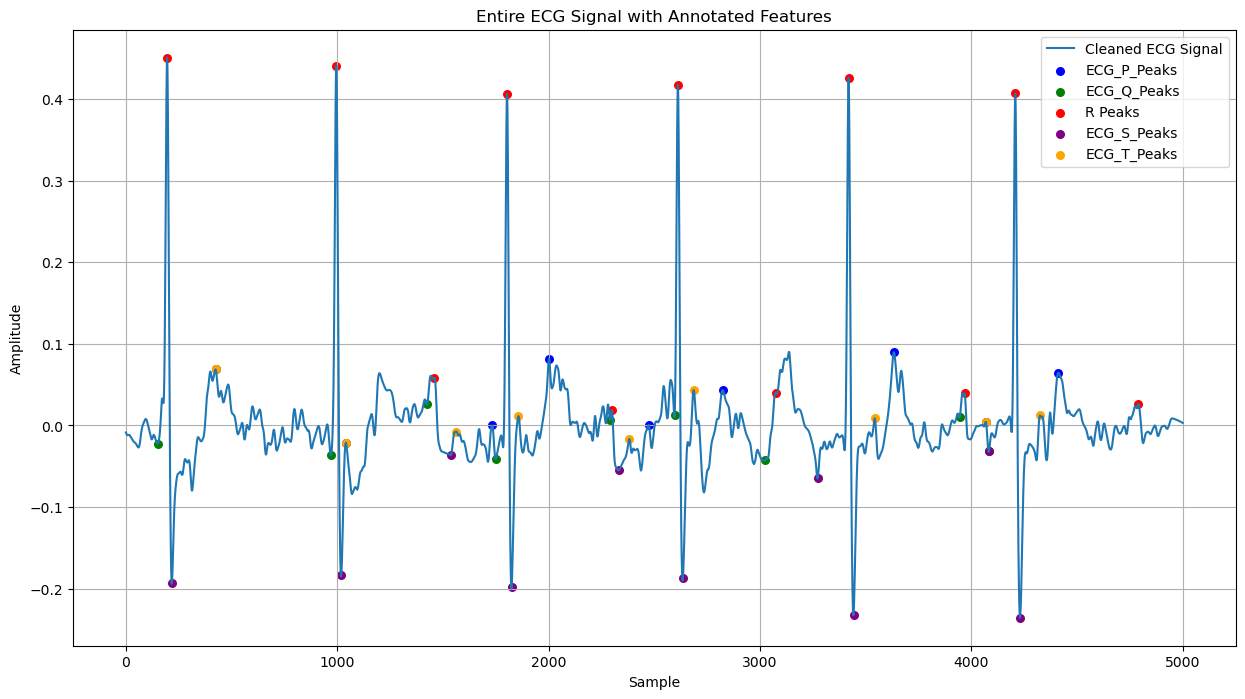

In [70]:
for i in range(len(classes)):
    label = classes[i]
    random_sample_row = chosen_random_samples[i]
    record = wfdb.rdrecord(directory + random_sample_row['filename_hr'].values[0])
    ecg_signal = record.p_signal[:, 0]  # Extract the first lead
    s_rate = 500

    # Clean the ECG signal
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=s_rate)

    # Detect R-peaks
    ecg_peaks, ecg_info = nk.ecg_peaks(ecg_cleaned, sampling_rate=s_rate)
    rpeaks = ecg_info["ECG_R_Peaks"]

   # Delineate the ECG signal using DWT
    signal_dwt, waves_dwt = nk.ecg_delineate(
        ecg_cleaned, 
        rpeaks={"ECG_R_Peaks": rpeaks}, 
        sampling_rate=s_rate, 
        method="cwt", 
        show=True,  # Automatically plots detected segments
        show_type="all"  # Show all detected features
    )

    qrs_onsets = np.array([x for x in waves_dwt.get("ECG_Q_Onsets", []) if not np.isnan(x)], dtype=int)
    qrs_offsets = np.array([x for x in waves_dwt.get("ECG_S_Offsets", []) if not np.isnan(x)], dtype=int)
    p_peaks = np.array([x for x in waves_dwt.get("ECG_P_Peaks", []) if not np.isnan(x)], dtype=int)
    t_peaks = np.array([x for x in waves_dwt.get("ECG_T_Peaks", []) if not np.isnan(x)], dtype=int)


    # Plot the entire signal with annotated features
    plt.figure(figsize=(15, 8))
    plt.plot(ecg_cleaned, label="Cleaned ECG Signal")

    # Annotate features from delineation
    features = ["ECG_P_Peaks", "ECG_Q_Peaks", "ECG_R_Peaks", "ECG_S_Peaks", "ECG_T_Peaks"]
    colors = ["blue", "green", "red", "purple", "orange"]

    for feature, color in zip(features, colors):
        if feature == "ECG_R_Peaks":
            plt.scatter(rpeaks, ecg_cleaned[rpeaks], color='red', label="R Peaks", s=30)
            continue
        indices = np.array([x for x in waves_dwt.get(feature, []) if not np.isnan(x)], dtype=int)
        if indices.size > 0:
            plt.scatter(indices, ecg_cleaned[indices], color=color, label=feature, s=30)

    plt.title("Entire ECG Signal with Annotated Features")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.show()